## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read csv logs
rows = pd.read_csv('datalog_train.csv')
angles = rows['angle'].tolist()
# samples = rows['image'].tolist()
# print("Number of training samples: ", len(angles))

In [3]:
# # split
# shuffle(samples, angles)
# imgs_train, imgs_valid, angles_train, angles_valid = train_test_split(samples, angles, test_size=0.3)

In [4]:
# load training data
with open('datatrain.pickle', mode='rb') as f:
    data = pickle.load(f)
    
train_imgs   = data['train_imgs']
train_angles = data['train_angles']
valid_imgs   = data['valid_imgs']
valid_angles = data['valid_angles']

# number of training examples
n_train = len(train_imgs)

# number of validation examples
n_valid = len(valid_imgs)

# shape images
image_shape = train_imgs[0].shape

# number of unique classes/labels
n_classes = len(np.unique(train_angles))

print("Total number of training examples: ", n_train + n_valid)
print("Image shape (resized from 128x128x3): ", image_shape)
print("Number of classes: ", n_classes)

Total number of training examples:  11000
Image shape (resized from 128x128x3):  (64, 64, 3)
Number of classes:  201


In [5]:
labels = np.unique(angles)
print((labels + np.max(labels)) * 10)

[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
   96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
  108.  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.
  120.  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.
  132.  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.
  144.  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.
  156.  157.  158.  159.  160.  161.  162.  163.  1

In [6]:
# constants
SIZE = 64
BATCH_SIZE = 64

EPOCHS = 10
LRATE = 0.001
STEPDECAY = 0.3
DECAYFREQ = 10

In [7]:
# data preprocessing pipeline
def resize(img):
    return cv2.resize(img, (SIZE, SIZE))

def random_shift(img):
    if random.randint(0, 1) == 0:
        return img
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)

def flip(img, angle):
    if random.randint(0, 1) == 0:
        return img, angle
    img = np.fliplr(img)
    angle = -angle
    return img, angle

def normalize(img):
    image = np.copy(img)
    image = image / 255. - 0.5
    return image

def random_shadow(img):
    if random.randint(0, 1) == 0:
        return img
    # set top x
    x_top = random.randint(0, img.shape[1])
    # set bottom x
    x_bot = random.randint(0, img.shape[1])
    if x_top >= img.shape[1] // 2:
        x_bot = random.randint(0, img.shape[1] // 2)
    if x_top > img.shape[1] // 2:
        x_bot = random.randint(img.shape[1] // 2, img.shape[1])
    # set corner x
    x3 = x4 = random.choice([0, img.shape[1]])
    # set y1, y2
    y1 = 0
    y2 = img.shape[0]
    # draw shadow
    overlay = np.copy(img)
    pts = np.array([[x_top, y1], [x3, y1], [x4, y2], [x_bot, y2]], np.int32)
    shadow = cv2.fillPoly(overlay, [pts], (0, 0, 0))
    alfa = random.uniform(0.2, 0.8)
    return cv2.addWeighted(shadow, alfa, img, 1 - alfa, 0)

In [7]:
# # preprocess data
# # training
# train_imgs = []
# train_angles = []
# for i in range(len(imgs_train)):
#     angle = angles_train[i]
#     img = mpimg.imread(imgs_train[i])
#     img = random_shift(img)
#     img = random_shadow(img)
#     img, angle = flip(img, angle)
#     img = resize(img)
#     img = normalize(img)
#     train_imgs.append(img)
#     train_angles.append((angle + np.max(labels)) * 10)

# # validation
# valid_imgs = []
# valid_angles = []
# for i in range(len(imgs_valid)):
#     angle = angles_valid[i]
#     img = mpimg.imread(imgs_valid[i])
#     img = resize(img)
#     img = normalize(img)
#     valid_imgs.append(img)
#     valid_angles.append((angle + np.max(labels)) * 10)

In [8]:
# import pickle

# save_dict = {'train_imgs':train_imgs,
#              'train_angles':train_angles,
#              'valid_imgs': valid_imgs,
#              'valid_angles':valid_angles}

# with open('datatrain.pickle', mode='wb') as f:
#     pickle.dump(save_dict, f)

## Network Architecture

In [8]:
# tensorflow graph placeholders
x = tf.placeholder(tf.float32, (None, SIZE, SIZE, 3), name='x')
y = tf.placeholder(tf.float32, (None), name='y')
one_hot_y = tf.one_hot(tf.cast(y, tf.int32), len(labels))

mode = tf.placeholder(tf.bool, name='mode')

In [9]:
# cnn architecture
layer1 = tf.layers.conv2d(inputs=x, filters=16, 
                          kernel_size=[5, 5], 
                          strides=(2, 2), 
                          padding='valid',
                          kernel_initializer=tf.contrib.keras.initializers.he_normal(),
                          kernel_regularizer=tf.contrib.keras.regularizers.l2(0.01),
                          activation=tf.nn.tanh)
print("layer1: ", layer1.get_shape())

layer2 = tf.layers.conv2d(inputs=layer1, filters=24, 
                          kernel_size=[5, 5], 
                          strides=(2, 2), 
                          padding='valid',
                          kernel_initializer=tf.contrib.keras.initializers.he_normal(),
                          kernel_regularizer=tf.contrib.keras.regularizers.l2(0.01),
                          activation=tf.nn.tanh)
print("layer2: ", layer2.get_shape())

flat = tf.reshape(layer2, [-1, 13 * 13 * 24])
layer3 = tf.layers.dense(inputs=flat, units=500, 
                         kernel_initializer=tf.contrib.keras.initializers.he_normal(),
                         activation=tf.nn.tanh)
dropout3 = tf.layers.dropout(inputs=layer3, rate=0.3, training=mode)
print("layer3: ", layer3.get_shape())

logits = tf.layers.dense(inputs=dropout3, units=len(labels))
print("logits: ", logits.get_shape())

layer1:  (?, 30, 30, 16)
layer2:  (?, 13, 13, 24)
layer3:  (?, 500)
logits:  (?, 201)


In [10]:
# training pipeline
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LRATE)
training_operation = optimizer.minimize(loss)

# model evaluation pipeline
prediction = tf.argmax(logits, 1)
error = tf.reduce_mean(tf.pow(tf.cast(prediction, tf.float32) - y, 2))
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy, loss_err = sess.run([accuracy_operation, error], feed_dict={x: batch_x, 
                                                                              y: batch_y, 
                                                                              mode: False})
        
        total_accuracy += accuracy * len(batch_x)
        total_loss += loss_err * len(batch_x)
    
    return total_loss / num_examples, total_accuracy / num_examples

In [11]:
# train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    accuracy_plot = []
    loss_plot = []
    num_examples = len(train_imgs)
    
    print("Training...")
    print()
    print("learning rate: ", LRATE)
    
    for epoch in range(EPOCHS):
        shuffle(train_imgs, train_angles)
        
        if (epoch + 1) != EPOCHS and (epoch + 1) % DECAYFREQ == 0:
            LRATE *= STEPDECAY
            print("New learning rate: ", LRATE)
            print()
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_imgs[offset:end], train_angles[offset:end]            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, mode: True})

        training_loss, training_acc = evaluate(train_imgs, train_angles)
        validation_loss, validation_acc = evaluate(valid_imgs, valid_angles)
        accuracy_plot.append((training_acc, validation_acc))
        loss_plot.append((training_loss, validation_loss))
        
        print("EPOCH {} ...".format(epoch + 1))
        print("Train acc = {:.3f}, Valid acc = {:.3f}".format(training_acc, validation_acc))
        print("Training loss = {:.3f}, Validation loss = {:.3f}".format(training_loss, validation_loss))
        print()       
    
    plot_acc = pd.DataFrame(accuracy_plot, columns=['train_acc', 'valid_acc'])
    plot_loss = pd.DataFrame(loss_plot, columns=['train_loss', 'valid_loss'])
        
    saver.save(sess, './tf_model/dev/model_tf')
    print("Model saved")

Training...

learning rate:  0.001
EPOCH 1 ...
Train acc = 0.230, Valid acc = 0.013
Training loss = 3531.971, Validation loss = 4814.393

EPOCH 2 ...
Train acc = 0.358, Valid acc = 0.016
Training loss = 1597.033, Validation loss = 2152.458

EPOCH 3 ...
Train acc = 0.472, Valid acc = 0.015
Training loss = 1175.385, Validation loss = 1889.711

EPOCH 4 ...
Train acc = 0.639, Valid acc = 0.017
Training loss = 765.816, Validation loss = 1674.342

EPOCH 5 ...
Train acc = 0.786, Valid acc = 0.018
Training loss = 446.155, Validation loss = 1648.372

EPOCH 6 ...
Train acc = 0.897, Valid acc = 0.018
Training loss = 229.161, Validation loss = 1575.782

EPOCH 7 ...
Train acc = 0.954, Valid acc = 0.016
Training loss = 107.653, Validation loss = 1618.498

EPOCH 8 ...
Train acc = 0.978, Valid acc = 0.019
Training loss = 36.919, Validation loss = 1545.191

EPOCH 9 ...
Train acc = 0.993, Valid acc = 0.020
Training loss = 10.603, Validation loss = 1480.941

EPOCH 10 ...
Train acc = 0.998, Valid acc = 0.

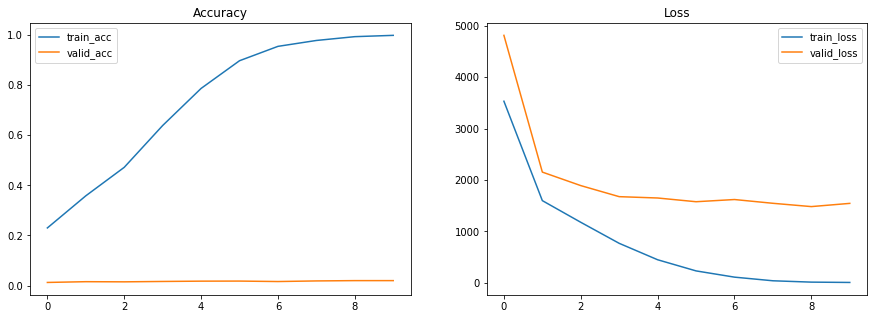

In [12]:
# plot loss
fig, (ax, ax2) = plt.subplots(ncols=2)
plot_acc.plot(title='Accuracy', figsize=(15, 5), ax=ax)
plot_loss.plot(title='Loss', figsize=(15, 5), ax=ax2)
plt.show()

## Evaluate model

In [13]:
# read csv logs
rows_test = pd.read_csv('datalog_test.csv')
angles_test = rows_test['angle'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  1000


In [9]:
# # load test data
# img_test = []
# ang_test = []

# for i in range(len(samples_test)-1):
#     angle = angles_test[i]
#     img = mpimg.imread(samples_test[i])
#     img = resize(img)
#     img = normalize(img)
#     img_test.append(img)
#     ang_test.append(angle)

# test_imgs = np.array(img_test)
# test_angles = np.array((ang_test + np.max(labels)) * 10)

In [58]:
# save_dict_test = {'test_imgs':test_imgs,
#                   'test_angles':test_angles}

# with open('datatest.pickle', mode='wb') as f:
#     pickle.dump(save_dict_test, f)

In [14]:
# load test data
with open('datatest.pickle', mode='rb') as f:
    data = pickle.load(f)
    
test_imgs   = data['test_imgs']
test_angles = data['test_angles']

In [15]:
# evaluate model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/dev/model_tf.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model/dev'))
    _, test_acc = evaluate(test_imgs, test_angles)
    print("Accuracy: {:.1f}%".format(test_acc*100))

INFO:tensorflow:Restoring parameters from ./tf_model/dev/model_tf
Accuracy: 1.3%


In [16]:
random.seed(7)
idx = []
t_a = []
t_i = []
for i in range(30):
    index = random.randint(0, len(angles_test)-1)
    angle = angles_test[index]
    img = mpimg.imread(samples_test[index])
    img = resize(img)
    img = normalize(img)
    
    idx.append(index)
    t_a.append((angle + np.max(labels)) * 10)
    t_i.append(img)
    

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/dev/model_tf.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model/dev'))
    predicted_label = tf.argmax(logits, 1)
    predictions = sess.run(predicted_label, feed_dict={x: t_i, mode: False})

for i in range(30):
    print("Image {}: predicted angle = {:.1f}, actual angle = {:.1f}".format(idx[i], 
                                                                    (predictions[i] / 10 - np.max(labels)),
                                                                    (t_a[i] / 10 - np.max(labels))))

INFO:tensorflow:Restoring parameters from ./tf_model/dev/model_tf
Image 331: predicted angle = -4.2, actual angle = -3.8
Image 970: predicted angle = -8.5, actual angle = -2.6
Image 154: predicted angle = -8.0, actual angle = -9.5
Image 404: predicted angle = -9.1, actual angle = -9.9
Image 666: predicted angle = -6.4, actual angle = -9.1
Image 49: predicted angle = -9.9, actual angle = -9.8
Image 74: predicted angle = -3.9, actual angle = -3.1
Image 840: predicted angle = -6.0, actual angle = -9.2
Image 548: predicted angle = 8.5, actual angle = 7.5
Image 96: predicted angle = 6.2, actual angle = 7.6
Image 374: predicted angle = 5.5, actual angle = 0.9
Image 596: predicted angle = -5.0, actual angle = 0.8
Image 59: predicted angle = 7.2, actual angle = 4.6
Image 931: predicted angle = -9.1, actual angle = -7.4
Image 519: predicted angle = 2.6, actual angle = 4.3
Image 219: predicted angle = 5.2, actual angle = 8.6
Image 38: predicted angle = -6.2, actual angle = -8.0
Image 88: predict

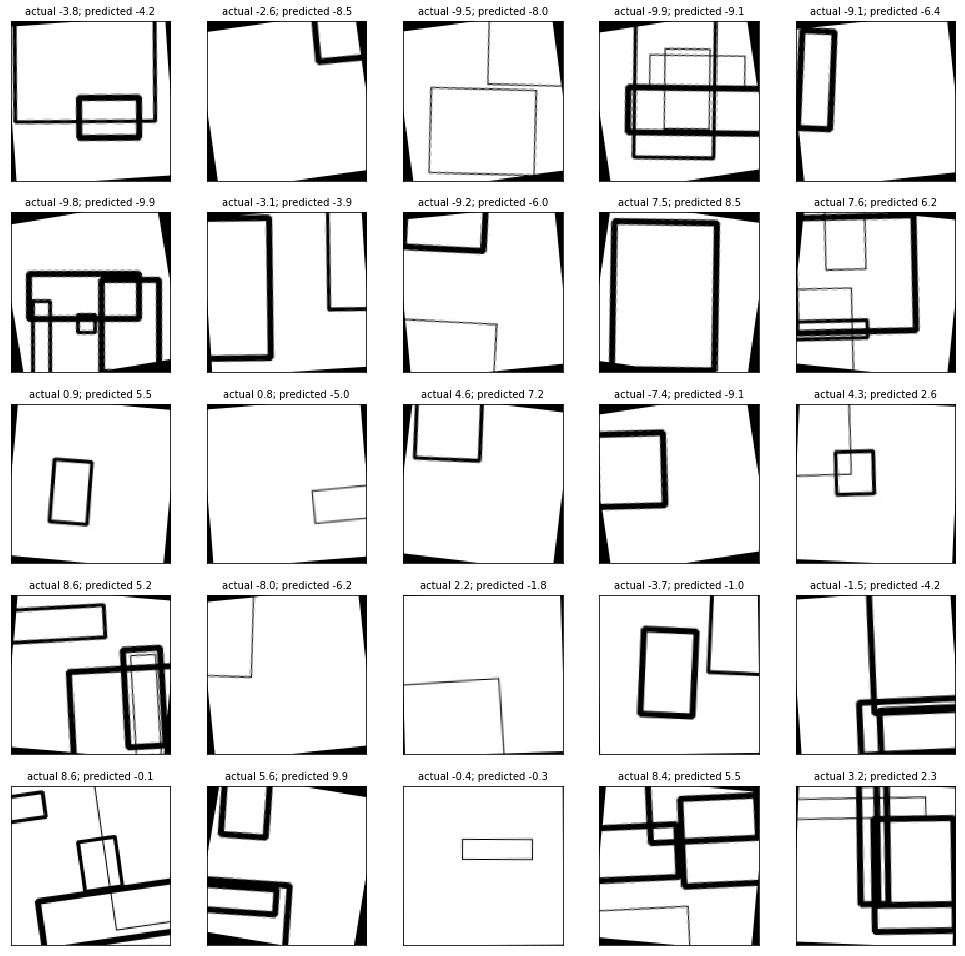

In [18]:
# angle correction
def rotate(img, ang):
    height, width, ch = img.shape
    sh = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, ang, 1.0)
    return cv2.warpAffine(img, M, sh)

n_rows = 5
n_cols = 5
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = mpimg.imread(samples_test[idx[i]])
    angle = angles_test[idx[i]]
    predicted_angle = predictions[i] / 10 - np.max(labels)
    # correct rotation
    image = rotate(image, -predicted_angle)
    # plot image
    plt.title('actual {}; predicted {}'.format(angle, round(predicted_angle,1)), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)